In [1]:
import pandas as pd
import numpy as np
from preprocessing import get_vocab, index_sents, SeparateInput, GetCharSentence, tag_input, bio_classification_report
from embedding import create_embeddings, create_embeddings_fastext
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#!pip install keras-tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers.wrappers import Bidirectional
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, \
    Flatten, concatenate, GRU
from keras_contrib.layers import CRF
from keras_contrib.utils import save_load_utils
from keras_tqdm import TQDMNotebookCallback
from embedding import load_vocab
from keras.initializers import RandomUniform
from keras.utils import plot_model
from keras.optimizers import Adam

In [3]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [4]:
class NerModel(object):
    
    def __init__(self,corpus, epochs=5, dropout=0.25, lstm_size=400, embedding_size=300, 
                 sentence_max_length=30, max_len_char=10, conv_size=3, batch_size=64 , learning_rate =0.001,
                  use_wemb=True, use_cemb=True, use_pemb=True, pretrained_embeddings=False):
        self.epochs = epochs
        self.dropout = dropout
        self.lstm_size = lstm_size
        self.embedding_size = embedding_size
        self.sentence_max_length = sentence_max_length
        self.max_len_char = max_len_char
        self.conv_size = conv_size
        self.pos_embedding = use_pemb
        self.word_embedding = use_wemb
        self.char_embedding = use_cemb
        self.CORPUS = corpus
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.pretrained_embeddings = pretrained_embeddings
        
    def loadData(self):
        if self.CORPUS == 'conll':
            self.train_sentences = pd.read_csv('./corpus/conll/conll_train.csv')
            self.dev_sentences = pd.read_csv('./corpus/conll/conll_test.csv')
            self.test_sentences = pd.read_csv('./corpus/conll/conll_dev.csv')
        
            
            if 'Unnamed: 0'  in self.train_sentences.columns:
                del self.train_sentences['Unnamed: 0']
            if 'Unnamed: 0'  in self.dev_sentences.columns:
                del self.dev_sentences['Unnamed: 0']
            if 'Unnamed: 0'  in self.test_sentences.columns:
                del self.test_sentences['Unnamed: 0']
                
        elif self.CORPUS == 'ancora':
            data = pd.read_csv('./corpus/ancora/ancora_corpus_pos.csv')
            
            if 'Unnamed: 0'  in data.columns:
                del data['Unnamed: 0']
                
            self.train_sentences, tmp_test = train_test_split(data, test_size=0.1, random_state=42, shuffle=True)
            self.test_sentences, self.dev_sentences =  train_test_split(tmp_test, test_size=0.5, random_state=42, shuffle=True)
            del data
            del tmp_test
            
        self.total_corpus = pd.concat([ self.train_sentences, self.dev_sentences, self.test_sentences])
    def separeteInput(self):
        
        self.sentence_train_text, self.sentence_train_post, self.sentence_train_ners = SeparateInput(self.train_sentences)
        self.sentence_dev_text, self.sentence_dev_post, self.sentence_dev_ners = SeparateInput(self.dev_sentences)
        self.sentence_test_text, self.sentence_test_post, self.sentence_test_ners = SeparateInput(self.test_sentences)
        self.sentence_text, self.sentence_post, self.sentence_ners = SeparateInput(self.total_corpus)
      
        
    def createVocabs(self):
        
        self.words = self.total_corpus['Word'].unique().tolist()
        self.nertags = self.total_corpus['Tag'].unique().tolist()
        self.postags = self.total_corpus['POS'].unique().tolist()
        
        self.MAX_VOCAB = len(self.words)
        
        self.word2idx, self.idx2word = get_vocab(self.sentence_text, self.MAX_VOCAB-2)
        self.pos2idx, self.idx2pos = get_vocab(self.sentence_post, len(set(self.postags))+2)
        self.ner2idx, self.idx2ner = get_vocab(self.sentence_ners, len(set(self.nertags))+2)
        
        self.TAG_VOCAB = len(list(self.idx2pos.keys()))
        self.NER_VOCAB = len(list(self.idx2ner.keys()))
        charSet = set()
        for sentence in self.sentence_text:
          #print(sentence)
          for token in sentence:
            for char1 in token:
                charSet.add(char1)
        chartList = list(charSet)
        
        self.char2idx = {"PAD": 0, "UNK": 1}
        for c in chartList:
            self.char2idx[c] = len(self.char2idx)
        
        self.idx2Char = {v: k for k, v in self.char2idx.items()}
        self.CHAR_VOCAB  = len(list(self.idx2Char))
    
    def createIndexes(self):
        
        #DATOS DE ENTRENAMIENTO
        self.sentence_train_text_idx = index_sents(self.sentence_train_text, self.word2idx)
        self.sentence_train_post_idx = index_sents(self.sentence_train_post, self.pos2idx)
        self.sentence_train_ners_idx = index_sents(self.sentence_train_ners, self.ner2idx)
        print("TRAIN:", str(len(self.sentence_train_post_idx)))
        #DATOS DE DEV
        self.sentence_dev_text_idx = index_sents(self.sentence_dev_text, self.word2idx)
        self.sentence_dev_post_idx = index_sents(self.sentence_dev_post, self.pos2idx)
        self.sentence_dev_ners_idx = index_sents(self.sentence_dev_ners, self.ner2idx)
        print("DEV:", str(len(self.sentence_dev_post_idx)))
        #DATOS DE TESTEO
        self.sentence_test_text_idx = index_sents(self.sentence_test_text, self.word2idx)
        self.sentence_test_post_idx = index_sents(self.sentence_test_post, self.pos2idx)
        self.sentence_test_ners_idx = index_sents(self.sentence_test_ners, self.ner2idx)
        print("TRAIN:", str(len(self.sentence_test_post_idx)))
        
        self.sentence_train_char_idx = GetCharSentence(self.sentence_train_text, self.sentence_max_length, self.max_len_char, self.char2idx)
        self.sentence_dev_char_idx = GetCharSentence(self.sentence_dev_text, self.sentence_max_length, self.max_len_char, self.char2idx)
        self.sentence_test_char_idx = GetCharSentence(self.sentence_test_text, self.sentence_max_length, self.max_len_char, self.char2idx)
    
    def padding(self):
        self.X_train_char = np.asarray(self.sentence_train_char_idx)
        self.X_dev_char = np.asarray(self.sentence_dev_char_idx)
        self.X_test_char = np.asarray(self.sentence_test_char_idx)
        
        
        
        self.X_train_sents = self.sentence_train_text_idx
        self.X_test_sents = self.sentence_test_text_idx
        self.X_dev_sents = self.sentence_dev_text_idx
        self.X_train_pos = self.sentence_train_post_idx
        self.X_test_pos = self.sentence_test_post_idx
        self.X_dev_pos = self.sentence_dev_post_idx
        
        self.Y_train_ner =  self.sentence_train_ners_idx
        self.Y_test_ner =  self.sentence_test_ners_idx
        self.Y_dev_ner =  self.sentence_dev_ners_idx
        
        self.Y_train_ner = sequence.pad_sequences(self.Y_train_ner, maxlen=self.sentence_max_length, truncating='post', padding='post')
        self.Y_test_ner = sequence.pad_sequences(self.Y_test_ner, maxlen=self.sentence_max_length, truncating='post', padding='post')
        self.Y_dev_ner = sequence.pad_sequences(self.Y_dev_ner, maxlen=self.sentence_max_length, truncating='post', padding='post')
        
        
        ##Reshape
        self.Y_train_ner = self.Y_train_ner[:, :, np.newaxis]
        self.Y_test_ner = self.Y_test_ner[:, :, np.newaxis]
        self.Y_dev_ner = self.Y_dev_ner[:, :, np.newaxis]

        # zero-pad the sequences to max length
        print("zero-padding sequences...\n")
        self.X_train_sents = sequence.pad_sequences(self.X_train_sents, maxlen=self.sentence_max_length, truncating='post', padding='post')
        self.X_test_sents = sequence.pad_sequences(self.X_test_sents, maxlen=self.sentence_max_length, truncating='post', padding='post')
        self.X_dev_sents = sequence.pad_sequences(self.X_dev_sents, maxlen=self.sentence_max_length, truncating='post', padding='post')
        self.X_train_pos = sequence.pad_sequences(self.X_train_pos, maxlen=self.sentence_max_length, truncating='post', padding='post')
        self.X_test_pos = sequence.pad_sequences(self.X_test_pos, maxlen=self.sentence_max_length, truncating='post', padding='post')
        self.X_dev_pos = sequence.pad_sequences(self.X_dev_pos, maxlen=self.sentence_max_length, truncating='post', padding='post')
    
    def embed(self):
        ### Embeddings de palabras y postag
        indices = [i for i in range(len(self.sentence_text))]
        if self.word_embedding and not self.pretrained_embeddings:
            
            train_sent_texts = [self.sentence_text[idx] for idx in indices]

            self.w2v_vocab, self.w2v_model = create_embeddings(train_sent_texts,
                                   embeddings_path='./embeddings/text_embeddings.gensimmodel',
                                   vocab_path='./embeddings/text_mapping.json',
                                   size=300,
                                   workers=4,
                                   iter=20)
            
            self.word_embedding_matrix = np.zeros((self.MAX_VOCAB, self.embedding_size))
            c = 0
            for word in self.word2idx.keys():
                # get the word vector from the embedding model
                # if it's there (check against vocab list)
                if word in self.w2v_vocab:
                    c += 1
                    # get the word vector
                    word_vector = self.w2v_model[word]
                    # slot it in at the proper index
                    self.word_embedding_matrix[self.word2idx[word]] = word_vector
            print("adicionados", c, "vectores")
        else:
            f =  open('./embeddings/SBW_w2v/SBW-vectors-300-min5.txt', encoding='utf-8') 
            embeddings_index = {}
            for a, line in enumerate(f):
                if a > 0:
                    values = line.split()
                    word = values[0]
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
            f.close()
            
            self.word_embedding_matrix = np.zeros((self.MAX_VOCAB, self.embedding_size))
            for t, (word, i) in enumerate(self.word2idx.items()):
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    # las palabras que no se encuentren en el índice de inserción serán todos ceros.
                    self.word_embedding_matrix[t] = embedding_vector

            print(self.word_embedding_matrix.shape)
            
        if self.pos_embedding:
            train_post_texts = [self.sentence_post[idx] for idx in indices]

            self.w2v_pvocab, self.w2v_pmodel = create_embeddings(train_post_texts,
                                     embeddings_path='./embeddings/pos_embeddings.gensimmodel',
                                     vocab_path='./embeddings/pos_mapping.json',
                                     size=300,
                                     workers=4,
                                     iter=20)
            
            self.pos_embedding_matrix = np.zeros((self.TAG_VOCAB, self.embedding_size))
            c = 0
            for word in self.pos2idx.keys():
                # get the word vector from the embedding model
                # if it's there (check against vocab list)
                if word in self.w2v_pvocab:
                    c += 1
                    # get the word vector
                    word_vector = self.w2v_pmodel[word]
                    # slot it in at the proper index
                    self.pos_embedding_matrix[self.pos2idx[word]] = word_vector
            print("adicionamos", c, "vectores")
    
    def builModel(self):
        ### Agregar capas
        #Char Embeddings
        txt_drpot =None
        char  = None
        pos_drpot = None
        mrg_cncat = None
        if self.char_embedding:
            char_input = Input(shape=(None, self.max_len_char),  name='char_input')
            #char_input = Input(shape=(self.sentence_max_length, self.max_len_char),  name='char_input')
            char_embed = TimeDistributed(Embedding(input_dim=self.CHAR_VOCAB,output_dim=300, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5), name="Character_embedding"))(char_input)
            char_drpot = Dropout(self.dropout, name='char_dropout', trainable=True)(char_embed)

            conv1d_out = TimeDistributed(Conv1D(kernel_size=self.conv_size, filters=100, padding='same', activation='tanh', strides=1), name="Convolution")(char_drpot)
            maxpool_out = TimeDistributed(MaxPooling1D(self.max_len_char), name="Maxpool")(conv1d_out)
            char = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
            char = Dropout(self.dropout)(char)

            
            print("Ready char!")
        
        
        #POS Embeddings
        if self.pos_embedding:
            pos_input = Input(shape=(None,), name='pos_input')
            #pos_input = Input(shape=(self.sentence_max_length,), name='pos_input')
            pos_embed = Embedding(self.TAG_VOCAB, self.embedding_size, #input_length=self.s,
                                  weights=[self.pos_embedding_matrix],
                                  name='pos_embedding', trainable=True)(pos_input)
            pos_drpot = Dropout(self.dropout, name='pos_dropout')(pos_embed)
            print("Ready POS!")
        
        ### WROD embeddings
        txt_input = Input(shape=(None,), name='txt_input')
        #txt_input = Input(shape=(self.sentence_max_length,), name='txt_input')
        txt_embed = Embedding(self.MAX_VOCAB, self.embedding_size, #input_length=MAX_LENGTH,
                              weights=[self.word_embedding_matrix],
                              name='txt_embedding', trainable=True)(txt_input)
        txt_drpot = Dropout(self.dropout, name='txt_dropout')(txt_embed)
        print("Ready Word!")
        
        if self.char_embedding and self.pos_embedding:
            mrg_cncat = concatenate([txt_drpot, pos_drpot, char])
        
        elif self.char_embedding:
            mrg_cncat = concatenate([txt_drpot, char])
                
        elif self.pos_embedding:
            mrg_cncat = concatenate([txt_drpot, pos_drpot])
        
        else:
             mrg_cncat = concatenate([txt_drpot])
                
            
        mrg_lstml = Bidirectional(LSTM(self.lstm_size, return_sequences=True),
                          name='mrg_bidirectional_1')(mrg_cncat)
        
        mrg_drpot = Dropout(self.dropout, name='mrg_dropout')(mrg_lstml)
        mrg_lstml = Bidirectional(LSTM(self.lstm_size, return_sequences=True),
                          name='mrg_bidirectional_2')(mrg_lstml)
        
        crf = CRF(self.NER_VOCAB, sparse_target=True)
        mrg_chain = crf(mrg_lstml)
        
        crf = CRF(self.NER_VOCAB, sparse_target=True)
        mrg_chain = crf(mrg_lstml)
        
        if self.char_embedding and self.pos_embedding:
            self.Model = Model(inputs=[txt_input, pos_input, char_input], outputs=mrg_chain)
        elif self.char_embedding:
            self.Model = Model(inputs=[txt_input, char_input], outputs=mrg_chain)
        elif self.pos_embedding:    
            self.Model = Model(inputs=[txt_input, pos_input], outputs=mrg_chain)
        else:
            self.Model = Model(inputs=txt_drpot, outputs=mrg_chain)
        
        optimizer = Adam(learning_rate=self.learning_rate)
        
        self.Model.compile(optimizer=optimizer,
              loss=crf.loss_function,
              metrics=[crf.accuracy])
    def train(self):
        if self.char_embedding and self.pos_embedding:
            self.history = self.Model.fit([self.X_train_sents, self.X_train_pos,  self.X_train_char], self.Y_train_ner,
                    batch_size=self.batch_size,
                    epochs=self.epochs,
                    validation_data=([self.X_dev_sents,self.X_dev_pos ,self.X_dev_char], self.Y_dev_ner),
                    verbose=0 ,callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
        elif self.char_embedding:
            self.history = self.Model.fit([self.X_train_sents, self.X_train_char], self.Y_train_ner,
                    batch_size=self.batch_size,
                    epochs=self.epochs,
                    validation_data=([self.X_dev_sents, self.X_dev_char],self.Y_dev_ner),
                    verbose=0 ,callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
        elif self.pos_embedding:
            self.history = self.Model.fit([self.X_train_sents, self.X_train_pos,  ], self.Y_train_ner,
                    batch_size=self.batch_size,
                    epochs=self.epochs,
                    validation_data=([self.X_dev_sents,self.X_dev_pos ], self.Y_dev_ner),
                    verbose=0 ,callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
        else:
            self.history = self.Model.fit(self.X_train_sents, self.Y_train_ner,
                    batch_size=self.batch_size,
                    epochs=self.epochs,
                    validation_data=(self.X_dev_sents, self.Y_dev_ner),
                    verbose=0 ,callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
    
    
        self.modelName = "{}_{}_{}_{}_{}_{}_{}".format(self.epochs, 
                                                        self.dropout, 
                                                        self.lstm_size,
                                                        self.conv_size,
                                                        self.learning_rate,
                                                        self.batch_size,
                                                        self.CORPUS
                                                       )
        self.Model.save('./models/'+ self.modelName + '.h5')
    
    def test(self):
        if self.char_embedding and self.pos_embedding:
            predictions = self.Model.predict([self.X_test_sents, self.X_test_pos, self.X_test_char])
        elif self.char_embedding:
            predictions = self.Model.predict([self.X_test_sents, self.X_test_char])
        elif self.pos_embedding:
            predictions = self.Model.predict([self.X_test_sents, self.X_test_pos])
        else:
            predictions = self.Model.predict(self.X_test_sents)
            
        predictions = np.argmax(predictions, axis=-1)
        
        trues = np.squeeze(self.Y_test_ner, axis=-1)
        
        s_preds = [[self.idx2ner[t] for t in s] for s in predictions]

        s_trues = [[self.idx2ner[t] for t in s] for s in trues]
        
        
        print("F1-score: {:.1%}".format(f1_score(s_preds, s_trues)))
        print("Recall-score: {:.1%}".format(recall_score(s_preds, s_trues)))
        print("Precision-score: {:.1%}".format(precision_score(s_preds, s_trues)))
        print("")
        print(classification_report(s_trues, s_preds))
        
        print("")
        print(bio_classification_report(s_trues, s_preds))
        
    def graphResults(self):
        if self.history is not None:
            plt.plot(self.history.history['crf_viterbi_accuracy'])
            plt.plot(self.history.history['val_crf_viterbi_accuracy'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'Dev'], loc='upper left')
            plt.show()
            # summarize history for loss
            plt.plot(self.history.history['loss'])
            plt.plot(self.history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'Dev'], loc='upper left')
            plt.show()
    def plot_model(self):
        plot_model(
            self.Model,
            to_file="model.png",
            show_shapes=True,
           # show_dtype=False,
            show_layer_names=True,
            rankdir="TB",
            #expand_nested=False,
           # dpi=96,
        )

In [5]:
Ner = NerModel(corpus='conll', epochs=20, batch_size=64, pretrained_embeddings=False, use_pemb = False)

In [6]:
print(Ner.__dict__)

{'epochs': 20, 'dropout': 0.25, 'lstm_size': 400, 'embedding_size': 300, 'sentence_max_length': 30, 'max_len_char': 10, 'conv_size': 3, 'pos_embedding': False, 'word_embedding': True, 'char_embedding': True, 'CORPUS': 'conll', 'batch_size': 64, 'learning_rate': 0.001, 'pretrained_embeddings': False}


In [7]:
%time
Ner.loadData()
Ner.separeteInput()
Ner.createVocabs()
Ner.createIndexes()
Ner.padding()

Wall time: 0 ns
TRAIN: 8323
DEV: 1517
TRAIN: 1915
zero-padding sequences...



In [8]:
Ner.X_train_char.shape

(8323, 30, 10)

In [9]:
%%time 
Ner.embed()

C:\Users\Camilo\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:165: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


adicionados 6947 vectores
Wall time: 5.43 s


In [10]:
%%time
Ner.builModel()

Ready char!
Ready Word!


C:\Users\Camilo\Anaconda3\envs\thesis\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
C:\Users\Camilo\Anaconda3\envs\thesis\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


Wall time: 3.11 s


In [11]:
%%time
Ner.Model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, None, 10)     0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 10, 300 27900       char_input[0][0]                 
__________________________________________________________________________________________________
char_dropout (Dropout)          (None, None, 10, 300 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
Convolution (TimeDistributed)   (None, None, 10, 100 90100       char_dropout[0][0]               
____________________________________________________________________________________________

In [12]:
Ner.plot_model()

In [13]:
Ner.train()

C:\Users\Camilo\Anaconda3\envs\thesis\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


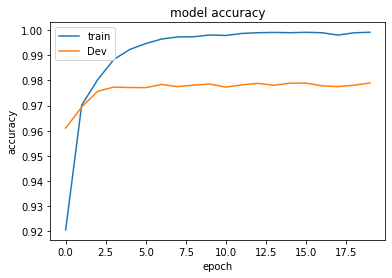

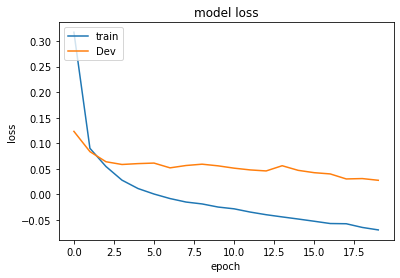

In [14]:
Ner.graphResults()

In [15]:
Ner.test()

F1-score: 82.1%
Recall-score: 82.7%
Precision-score: 81.6%

           precision    recall  f1-score   support

      PAD       1.00      1.00      1.00      1002
      ORG       0.84      0.73      0.78      1297
      PER       0.85      0.86      0.86       949
      LOC       0.72      0.83      0.77       747
     MISC       0.45      0.44      0.44       332

micro avg       0.83      0.82      0.82      4327
macro avg       0.83      0.82      0.82      4327




C:\Users\Camilo\Anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\Camilo\Anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

       B-LOC       0.73      0.84      0.78       746
       I-LOC       0.71      0.77      0.74       261
      B-MISC       0.57      0.50      0.53       332
      I-MISC       0.61      0.55      0.58       461
       B-ORG       0.88      0.75      0.81      1297
       I-ORG       0.85      0.73      0.78       947
       B-PER       0.88      0.88      0.88       949
       I-PER       0.94      0.91      0.92       652

   micro avg       0.81      0.77      0.79      5645
   macro avg       0.77      0.74      0.75      5645
weighted avg       0.81      0.77      0.79      5645
 samples avg       0.08      0.08      0.08      5645

